In [1]:
%env XLA_PYTHON_CLIENT_PREALLOCATE=false
import numpy as np
from jax import jit, random, tree_util
import jax, optax, sys, os, pickle, datetime
import flax.linen as nn
from time import time
from functools import partial
# Path to deepmd_jax; change if you're running this script from a different directory
sys.path.append(os.path.abspath('../'))
from deepmd_jax.data import DPDataset
from deepmd_jax.dpmodel import DPModel
print('Program start at', datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), 'on device:', jax.devices()[:1])
TIC = time()
# Recommended to use 32 bit, you can change to 16 (for mixed 32/16 bit) or 64 bit
precision      = '32' # '16' '32' '64'
if precision == '32':
    jax.config.update('jax_default_matmul_precision', 'float32')
if precision == '64':
    jax.config.update('jax_enable_x64', True)

# Beginning config parameters; change as you need
save_name      = 'trained_models/model_water_new.pkl' # model save path
model_type     = 'energy'      # 'energy': global scalar model; 'atomic': atomic vector model e.g. wannier 
atomic_sel     = [0]           # select atom type for model predictions (only for 'atomic' model)
# Please prepare your dataset in the same format as DeepMD-kit
# You can use nested data paths like [[dat1,dat2],[dat3]]; but make sure dat1,dat2 have the same type_map
train_data     = DPDataset(['data/polaron_train/'], ['coord', 'box', 'force', 'energy'])
# train_data     = DPDataset(['data/mdsim/lips/train/'], ['coord', 'box', 'force', 'energy'])
# train_data     = DPDataset(['data/wannier_water/0data/'], ['coord', 'box', 'atomic_dipole'], {'atomic_sel':atomic_sel})
use_val_data   = True          # if False, comment next line
val_data       = DPDataset(['data/polaron_val/'], ['coord', 'box', 'force', 'energy'])
# val_data       = DPDataset(['data/mdsim/lips/val/'], ['coord', 'box', 'force', 'energy'])
rcut           = 6.0           # cutoff radius (Angstrom)
use_2nd_tensor = True         # Use 2nd order tensor descriptor for more accuracy (usually recommended, slightly slower)
use_mp         = False         # Use message passing (DP-MP) model for even more accuracy (slower)  
embed_widths   = [16,32,64]    # # Recommended: [16,32,64] ([24,48,96] for accuracy) for DP; [32,32] for DP-MP
embedMP_widths = [64,32,64]    # MP width; Recommended: [64,32,64] ([64,64,64] for accuracy, [32,32,32] for speed)
fit_widths     = [64,64,64]    # For 'atomic' model, assert fit_widths[-1,] == embed_widths[-1](DP) or embedMP_widths[-1](DP-MP)
axis_neurons   = 12            # Recommended: 8-12; Most of network parameters are in this layer
batch_size     = 1             # training batch size, Recommended: labels_per_frame * batch_size in (128, 512)
val_batch_size = 8             # validation batch size. Beware: too much can cause OOM error.
lr             = 0.002         # learning rate at the beginning, Recommended: 1e-3 or 2e-3 for DP/DP-MP, 1e-2 for atomic
s_pref_e       = 0.02          # starting prefactor for energy loss
l_pref_e       = 1             # limit prefactor for energy loss
s_pref_f       = 1000          # starting prefactor for force loss
l_pref_f       = 1             # limit prefactor for force loss
total_steps    = 500000        # total training steps; Recommended: 5e5-1e6 for DP/DP-MP, 5e4-2e5 for atomic
print_every    = 1000          # print loss and conduct validation every print_every steps in output
# parameters you usually don't need to worry about
limit_lr       = 1e-6          # learning rate at the end of training
beta2          = 0.99          # adam optimizer parameter
l_smoothing    = 20            # smoothing factor for loss display
decay_steps    = 5000          # learning rate decays every decay_steps
getstat_bs     = 64            # batch size for computing model statistics at the beginning

# From here on you don't need to change anything unless you know what you are doing
model = DPModel({'embed_widths':embed_widths,
                 'embedMP_widths':embedMP_widths if use_mp else None,
                 'fit_widths':fit_widths,
                 'axis':axis_neurons,
                 'Ebias':train_data.fit_energy() if model_type == 'energy' else None,
                 'rcut':rcut,
                 'use_2nd':use_2nd_tensor,
                 'use_mp':use_mp,
                 'atomic':True if model_type == 'atomic' else False,
                 'nsel':atomic_sel if model_type == 'atomic' else None,
                 'out_norm': 1. if model_type == 'energy' else train_data.get_atomic_label_scale()})
train_data.compute_lattice_candidate(rcut)
if use_val_data:
    val_data.compute_lattice_candidate(rcut)
batch, type_idx, lattice_args = train_data.get_batch(getstat_bs)
static_args         = nn.FrozenDict({'type_idx':type_idx, 'lattice':lattice_args})
model.get_stats(batch['coord'], batch['box'], static_args)
print('Model statistics computed.')
variables           = model.init(random.PRNGKey(np.random.randint(42)), batch['coord'][0], batch['box'][0], static_args)
print('\'%s\' model initialized (float%s). Parameter count: %d' %
      (model_type, precision, sum(i.size for i in tree_util.tree_flatten(variables)[0])))
lr_scheduler        = optax.exponential_decay(init_value=lr, transition_steps=decay_steps,
                        decay_rate=(limit_lr/lr)**(decay_steps/(total_steps-decay_steps)), transition_begin=0, staircase=True)
optimizer           = optax.adam(learning_rate=lr_scheduler, b2=beta2)
opt_state           = optimizer.init(variables)
loss, loss_and_grad = model.get_loss_fn()
print('Optimizer initialized. Starting training...')

state = {'loss_avg':0., 'iteration':0} | ({} if model_type == 'atomic' else {'le_avg':0., 'lf_avg':0.})
@partial(jit, static_argnums=(4,))
def train_step(batch, variables, opt_state, state, static_args):
    r = lr_scheduler(state['iteration']) / lr
    if model_type == 'energy':
        pref = {'e': s_pref_e*r + l_pref_e*(1-r), 'f': s_pref_f*r + l_pref_f*(1-r)}
        (loss_total, (loss_e, loss_f)), grads = loss_and_grad(variables, batch, pref, static_args)
        for key, value in zip(['loss_avg', 'le_avg', 'lf_avg'], [loss_total, loss_e, loss_f]):
            state[key] = state[key] * (1-1/l_smoothing) + value
    else:
        loss_total, grads = loss_and_grad(variables, batch, static_args)
        state['loss_avg'] = state['loss_avg'] * (1-1/l_smoothing) + loss_total
    updates, opt_state = optimizer.update(grads, opt_state, variables)
    variables = optax.apply_updates(variables, updates)
    state['iteration'] += 1
    return variables, opt_state, state

@partial(jit, static_argnums=(2,))
def val_step(batch, variables, static_args):
    if model_type == 'energy':
        pref = {'e': 1, 'f': 1}
        _, (loss_e, loss_f) = loss(variables, batch, pref, static_args)
        return loss_e, loss_f
    else:
        loss_total = loss(variables, batch, static_args)
        return loss_total

tic = time()
for iteration in range(total_steps):
    batch, type_idx, lattice_args = train_data.get_batch(batch_size)
    static_args = nn.FrozenDict({'type_idx':tuple(type_idx), 'lattice':lattice_args})
    variables, opt_state, state = train_step(batch, variables, opt_state, state, static_args)
    if iteration % print_every == 0:
        if use_val_data:
            val_batch, type_idx, lattice_args = val_data.get_batch(val_batch_size)
            static_args = nn.FrozenDict({'type_idx':tuple(type_idx), 'lattice':lattice_args})
            loss_val = val_step(val_batch, variables, static_args)
        beta = l_smoothing * (1 - (1/l_smoothing)**(iteration+1))
        print('Iter %7d' % iteration
              + ' L %7.5f' % (state['loss_avg']/beta)**0.5
              + (' LE %7.5f' % (state['le_avg']/beta)**0.5 if model_type == 'energy' else '')
              + (' LF %7.5f' % (state['lf_avg']/beta)**0.5 if model_type == 'energy' else '')
              + (' LEval %7.5f' % loss_val[0]**0.5 if model_type == 'energy' and use_val_data else '')
              + (' LFval %7.5f' % loss_val[1]**0.5 if model_type == 'energy' and use_val_data else '')
              + (' Lval %7.5f' % loss_val**0.5 if model_type == 'atomic' and use_val_data else '')
              + ' Time %.2fs' % (time()-tic))
        tic = time()

with open(save_name, 'wb') as file:
    pickle.dump({'model':model, 'variables':variables}, file)
T = int(time() - TIC)
print('Model saved to \'%s\'.' % save_name)
print('Training finished in %dh %dm %ds.' % (T//3600,(T%3600)//60,T%60))

env: XLA_PYTHON_CLIENT_PREALLOCATE=false
Program start at 2023-11-05 17:26:17 on device: [cuda(id=0)]
Dataset loaded: 28928 frames/384 atoms. Path: 
	'/global/u2/r/ruiqig/deepmd-jax/examples/data/polaron_train'
Dataset loaded: 3221 frames/384 atoms. Path: 
	'/global/u2/r/ruiqig/deepmd-jax/examples/data/polaron_val'
Lattice vectors for neighbor images: Max 1 out of 1 condidates.
Lattice vectors for neighbor images: Max 1 out of 1 condidates.
Model statistics computed.
'energy' model initialized (float32). Parameter count: 126274
Optimizer initialized. Starting training...
Iter       0 L 5.86116 LE 0.00757 LF 0.18535 LEval 0.13429 LFval 0.85546 Time 6.89s
Iter    1000 L 4.89634 LE 0.01034 LF 0.15484 LEval 0.00522 LFval 0.13595 Time 7.39s
Iter    2000 L 3.40109 LE 0.01094 LF 0.10755 LEval 0.01797 LFval 0.12948 Time 3.80s
Iter    3000 L 2.63635 LE 0.00512 LF 0.08337 LEval 0.00986 LFval 0.09955 Time 3.80s


KeyboardInterrupt: 

In [ ]:
var_name = ['/'.join([j.key for j in i[0]][1:]) for i in tree_util.tree_flatten_with_path(variables)[0]]
var_value = tree_util.tree_leaves(variables)
print('\n'.join([str(i.shape) + j for i, j in zip(var_value, var_name)]))

(64,)Tbias
(32,)embedding_net_0/Dense_0/bias
(1, 32)embedding_net_0/Dense_0/kernel
(32,)embedding_net_0/Dense_1/bias
(32, 32)embedding_net_0/Dense_1/kernel
(32, 32)embedding_net_0/Dense_2/kernel
(32,)embedding_net_1/Dense_0/bias
(1, 32)embedding_net_1/Dense_0/kernel
(32,)embedding_net_1/Dense_1/bias
(32, 32)embedding_net_1/Dense_1/kernel
(32, 32)embedding_net_1/Dense_2/kernel
(32,)embedding_net_10/Dense_0/bias
(1, 32)embedding_net_10/Dense_0/kernel
(32,)embedding_net_10/Dense_1/bias
(32, 32)embedding_net_10/Dense_1/kernel
(32,)embedding_net_11/Dense_0/bias
(1, 32)embedding_net_11/Dense_0/kernel
(32,)embedding_net_11/Dense_1/bias
(32, 32)embedding_net_11/Dense_1/kernel
(64,)embedding_net_12/Dense_0/bias
(64, 64)embedding_net_12/Dense_0/kernel
(64,)embedding_net_12/Dense_1/bias
(64, 64)embedding_net_12/Dense_1/kernel
(64,)embedding_net_12/bias
(64,)embedding_net_12/dt2
(64,)embedding_net_13/Dense_0/bias
(64, 64)embedding_net_13/Dense_0/kernel
(64,)embedding_net_13/Dense_1/bias
(64, 64)em

In [12]:
var = pickle.load(open('trained_models/dpmp_polaron_1.pkl', 'rb'))['variables']
var_name = ['/'.join([j.key for j in i[0]][1:]) for i in tree_util.tree_flatten_with_path(var)[0]]
var_value = tree_util.tree_leaves(var)
print('\n'.join([str(i.shape) + j for i, j in zip(var_value, var_name)]))

(64,)Tbias
(32,)embedding_net_0/Dense_0/bias
(1, 32)embedding_net_0/Dense_0/kernel
(32,)embedding_net_0/Dense_1/bias
(32, 32)embedding_net_0/Dense_1/kernel
(32, 32)embedding_net_0/Dense_2/kernel
(32,)embedding_net_1/Dense_0/bias
(1, 32)embedding_net_1/Dense_0/kernel
(32,)embedding_net_1/Dense_1/bias
(32, 32)embedding_net_1/Dense_1/kernel
(32, 32)embedding_net_1/Dense_2/kernel
(32,)embedding_net_10/Dense_0/bias
(1, 32)embedding_net_10/Dense_0/kernel
(32,)embedding_net_10/Dense_1/bias
(32, 32)embedding_net_10/Dense_1/kernel
(32,)embedding_net_11/Dense_0/bias
(1, 32)embedding_net_11/Dense_0/kernel
(32,)embedding_net_11/Dense_1/bias
(32, 32)embedding_net_11/Dense_1/kernel
(64,)embedding_net_12/Dense_0/bias
(64, 64)embedding_net_12/Dense_0/kernel
(64,)embedding_net_12/Dense_1/bias
(64, 64)embedding_net_12/Dense_1/kernel
(64,)embedding_net_12/bias
(64,)embedding_net_12/dt2
(64,)embedding_net_13/Dense_0/bias
(64, 64)embedding_net_13/Dense_0/kernel
(64,)embedding_net_13/Dense_1/bias
(64, 64)em

In [2]:
lattice_args

{'lattice_cand': ((0, -1, 0, 0, 0, 1, 0),
  (-1, 0, 0, 0, 0, 0, 1),
  (0, 0, -1, 0, 1, 0, 0)),
 'lattice_max': 2,
 'ortho': True}

In [4]:
train_data.data['box'].min(0)

array([[11.73857,  0.     ,  0.     ],
       [ 0.     , 11.73857,  0.     ],
       [ 0.     ,  0.     , 11.73857]], dtype=float32)

In [4]:
i = 3
e, debug = model.apply(variables, train_data.data['coord'][i], train_data.data['box'][i], static_args)
(r_NM, R_3NM, T_NXC, G0_ND, G1_ND, G2_ND, G_12_ND, G_ND, fit_n1) = debug
print('\n'.join(['%.5f' % np.std(i).item() for i in [G0_ND, G1_ND, G2_ND, G_12_ND, G_ND]]), '\n...')
print('\n'.join(['%.5f' % np.max(i).item() for i in [G0_ND, G1_ND, G2_ND, G_12_ND, G_ND]]), '\n...')
# print('\n'.join(['%.5f' % np.std(i).item() for i in [G0_ND[:,:16], G1_ND[:,:16], G2_ND[:,:16]]]))

0.33546
0.04005
0.10120
0.01354
0.14735 
...
2.15902
0.46571
1.06781
0.16159
2.15902 
...


([Array([ 0.26192066,  0.08257473, -0.20926486,  0.0276611 ,  0.11616737,
          0.11319254, -0.02616419, -0.11902571,  0.0029963 ,  0.23777695,
         -0.03699532, -0.13412759,  0.1318867 ,  0.34043556,  0.06990686,
          0.08816994, -0.10973369, -0.11346874,  0.08188233, -0.02579753,
         -0.04291397, -0.10516357, -0.00103865,  0.01513572, -0.05426645,
          0.02742819,  0.0592026 ,  0.03583718, -0.03883531,  0.0997284 ,
          0.02485579,  0.1618442 , -0.09363708, -0.05792553,  0.07835878,
         -0.0955013 ,  0.17588778,  0.09027172, -0.31220648, -0.25402728,
         -0.09860673,  0.13370277, -0.08613375,  0.49797428, -0.17855556,
         -0.03551122, -0.10979084,  0.03636498,  0.25501034, -0.26261744,
          0.11725393, -0.2845398 ,  0.13229012,  0.01223546, -0.12566729,
          0.09800548,  0.06638388, -0.14661518,  0.01507564,  0.12489685,
         -0.09653934, -0.06079413, -0.05723648,  0.00454839], dtype=float32),
  Array([-1.2785387 , -0.20324166,

SingleDataSystem loaded from: 
 '/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/2'
 with 1153 frames and 192 atoms per frame.


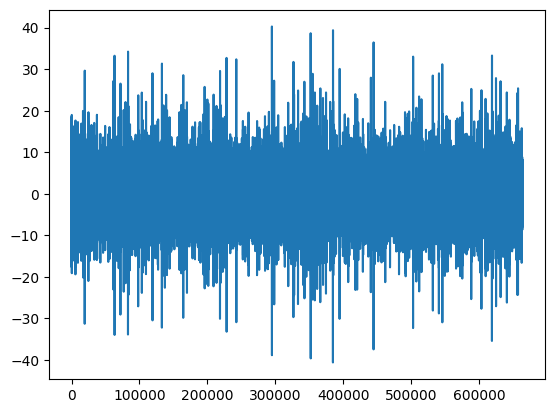

In [9]:
# train_data = SingleDataSystem(['data/water_yifan/2'], ['coord', 'box', 'force', 'energy'])
# import matplotlib.pyplot as plt
# plt.plot(train_data.data['force'].flatten())

In [2]:
import numpy as np
# path = 'data_ex6'
box = np.load('/global/homes/r/ruiqig/deepmd-jax/examples/data/water_yifan/2/set.000/box.npy').min(axis=0)
# natoms = np.load('/global/homes/r/ruiqig/deepmd-jax/examples/data/water_chunyi/data/' + path + '/set.000/coord.npy').shape[1] // 3
print(box) 
# print(natoms)

[14.659093  0.        0.        0.       13.902575  0.        0.
  0.        8.470338]


In [6]:
path = '/global/homes/r/ruiqig/deepmd-jax/examples/data/water_yifan/'
paths = [path + '1/']

In [7]:
coord, box, energy, force = [], [], [], []
for path in paths:
    coord.append(np.load(path + '/set.000/coord.npy'))
    force.append(np.load(path + '/set.000/force.npy'))
    box.append(np.load(path + '/set.000/box.npy'))
    energy.append(np.load(path + '/set.000/energy.npy'))
coord = np.concatenate(coord)
box = np.concatenate(box)
energy = np.concatenate(energy)
force = np.concatenate(force)
idx = ((box[:,::4]).min(1) > 12)
# idx = ((box[:,::4]).min(1) > 10)
print(box.shape, coord.shape, energy.shape, force.shape)
box = box[idx]
coord = coord[idx]
energy = energy[idx]
force = force[idx]
print(box.shape, coord.shape, energy.shape, force.shape)
np.save('/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/11/set.000/coord.npy', coord)
np.save('/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/11/set.000/box.npy', box)
np.save('/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/11/set.000/energy.npy', energy)
np.save('/global/u2/r/ruiqig/deepmd-jax/examples/data/water_yifan/11/set.000/force.npy', force)

(1517, 9) (1517, 576) (1517,) (1517, 576)
(1502, 9) (1502, 576) (1502,) (1502, 576)


In [32]:
paths = ['data%d' % i for i in range(1, 46)] + ['data_ex%d' % i for i in range(1, 7)]
paths = ['/global/homes/r/ruiqig/deepmd-jax/examples/data/water_chunyi/data/' + path for path in paths]